In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv("Chen_et_al_2018.csv")

df = df.dropna(subset=["mean_RT", "acc"])

simulated_data = []
np.random.seed(42)

for _, row in df.iterrows():
    word = row["word"]
    mean_rt = row["mean_RT"]
    accuracy = row["acc"]

    for _ in range(20):
        rt = np.random.normal(mean_rt, 100) 
        rt = max(rt, 100) 
        correct = np.random.rand() < accuracy
        simulated_data.append({
            "word": word,
            "rt": rt,
            "correct": int(correct)
        })

sim_df = pd.DataFrame(simulated_data)

sim_df.to_csv("simulated_trials.csv", index=False)

print(sim_df.head())

       word          rt  correct
0  absolute  839.161415        1
1  absolute  775.663570        1
2  absolute  766.074663        1
3  absolute  766.076304        1
4  absolute  947.411282        1


Number of trials: 7400
Number of unique words: 370
Average RT: 810.31 ms
Average accuracy: 0.85


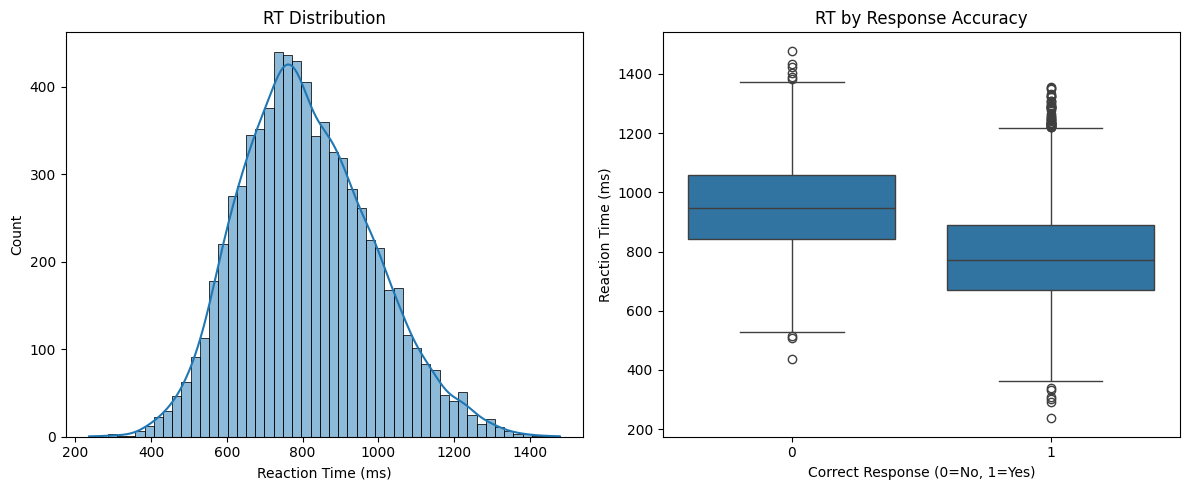

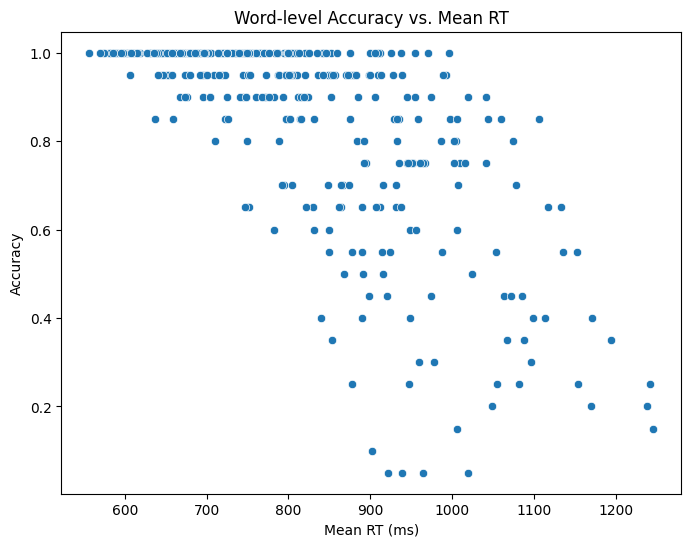

In [ ]:
import seaborn as sns

sim_df = pd.read_csv("simulated_trials.csv")

print(f"Number of trials: {len(sim_df)}")
print(f"Number of unique words: {sim_df['word'].nunique()}")
print(f"Average RT: {sim_df['rt'].mean():.2f} ms")
print(f"Average accuracy: {sim_df['correct'].mean():.2f}")

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(sim_df['rt'], kde=True)
plt.title('RT Distribution')
plt.xlabel('Reaction Time (ms)')

plt.subplot(1, 2, 2)
sns.boxplot(x='correct', y='rt', data=sim_df)
plt.title('RT by Response Accuracy')
plt.xlabel('Correct Response (0=No, 1=Yes)')
plt.ylabel('Reaction Time (ms)')

plt.tight_layout()
plt.show()

word_summary = sim_df.groupby('word').agg(
    mean_rt=('rt', 'mean'),
    accuracy=('correct', 'mean')
).reset_index()

plt.figure(figsize=(8, 6))
sns.scatterplot(x='mean_rt', y='accuracy', data=word_summary)
plt.title('Word-level Accuracy vs. Mean RT')
plt.xlabel('Mean RT (ms)')
plt.ylabel('Accuracy')
plt.show()

In [ ]:
import cmdstanpy
import os

stan_code = """
data {
  int<lower=1> N;                
  array[N] real<lower=0> rt;    
  array[N] int<lower=0, upper=1> resp; 
}

parameters {
  real<lower=0> a;            
  real<lower=0, upper=1> z;   
  real<lower=0> t0;           
  real v;                     
  real<lower=0> sv;           
}

model {
  a ~ normal(1.5, 0.5) T[0,];  
  z ~ beta(2, 2);            
  t0 ~ normal(0.3, 0.1) T[0,];
  v ~ normal(2, 1);
  sv ~ normal(0.5, 0.5) T[0,];

  for (n in 1:N) {
    real drift = v * (2*resp[n] - 1);
    real mu_rt = (a/(2*drift)) * tanh(drift*a/2) + t0;
    real sigma_rt = sqrt((a^2)/(2*drift^2) * (1 - (tanh(drift*a/2))^2)) + sv;
    
    target += normal_lpdf(rt[n] | mu_rt, sigma_rt) - 
              normal_lccdf(0 | mu_rt, sigma_rt); 
  }
}

generated quantities {
  array[N] real log_lik;
  array[N] real rt_pred;
  
  for (n in 1:N) {
    real drift = v * (2*resp[n] - 1);
    real mu_rt = (a/(2*drift)) * tanh(drift*a/2) + t0;
    real sigma_rt = sqrt((a^2)/(2*drift^2) * (1 - (tanh(drift*a/2))^2)) + sv;
    
    log_lik[n] = normal_lpdf(rt[n] | mu_rt, sigma_rt) - 
                 normal_lccdf(0 | mu_rt, sigma_rt);
                 
    rt_pred[n] = normal_rng(mu_rt, sigma_rt);
    while (rt_pred[n] <= 0)
      rt_pred[n] = normal_rng(mu_rt, sigma_rt);
  }
}
"""

model_file = "ddm_model.stan"
with open(model_file, "w") as f:
    f.write(stan_code)

/Users/raamizabbasi/anaconda3/envs/cognitive/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
stan_code_simple = """
data {
  int<lower=1> N;                
  array[N] real<lower=0> rt;     
  array[N] int<lower=0, upper=1> resp; 
}

parameters {
  real<lower=0> a;               
  real<lower=0, upper=1> z;     
  real<lower=0> t0;              
  real v;                       
}

model {
  a ~ normal(1.5, 0.5) T[0,];  
  z ~ beta(2, 2);            
  t0 ~ normal(0.3, 0.1) T[0,];
  v ~ normal(2, 1);
  
  for (n in 1:N) {
    real drift = v * (2*resp[n] - 1);
    real mu_rt = (a/(2*drift)) + t0;
    real sigma_rt = 0.1;
    
    target += normal_lpdf(rt[n] | mu_rt, sigma_rt) - 
              normal_lccdf(0 | mu_rt, sigma_rt);
  }
}

generated quantities {
  array[N] real rt_pred;
  
  for (n in 1:N) {
    real drift = v * (2*resp[n] - 1);
    real mu_rt = (a/(2*drift)) + t0;
    real sigma_rt = 0.1;
    
    rt_pred[n] = normal_rng(mu_rt, sigma_rt);
    while (rt_pred[n] <= 0)
      rt_pred[n] = normal_rng(mu_rt, sigma_rt);
  }
}
"""

with open("ddm_model_simple.stan", "w") as f:
    f.write(stan_code_simple)

model_simple = cmdstanpy.CmdStanModel(stan_file="ddm_model_simple.stan")

sample_size = min(500, len(sim_df))
sample_indices = np.random.choice(len(sim_df), sample_size, replace=False)
sample_df = sim_df.iloc[sample_indices]

stan_data_simple = {
    'N': len(sample_df),
    'rt': (sample_df['rt'].values / 1000).tolist(),
    'resp': sample_df['correct'].values.tolist()
}

fit_simple = model_simple.sample(
    data=stan_data_simple,
    iter_sampling=500,
    iter_warmup=250,
    chains=2,
    seed=42,
    show_progress=True
)

14:45:20 - cmdstanpy - INFO - compiling stan file /Users/raamizabbasi/CognitiveModeling/finalproject/ddm_model_simple.stan to exe file /Users/raamizabbasi/CognitiveModeling/finalproject/ddm_model_simple
14:45:25 - cmdstanpy - INFO - compiled model executable: /Users/raamizabbasi/CognitiveModeling/finalproject/ddm_model_simple
14:45:25 - cmdstanpy - INFO - CmdStan start processing
chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     


14:45:29 - cmdstanpy - INFO - CmdStan done processing.
14:45:29 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Location parameter is inf, but must be finite! (in 'ddm_model_simple.stan', line 29, column 4 to line 30, column 48)
	Exception: normal_lpdf: Location parameter is inf, but must be finite! (in 'ddm_model_simple.stan', line 29, column 4 to line 30, column 48)
	Exception: normal_lpdf: Location parameter is inf, but must be finite! (in 'ddm_model_simple.stan', line 29, column 4 to line 30, column 48)
	Exception: normal_lpdf: Location parameter is inf, but must be finite! (in 'ddm_model_simple.stan', line 29, column 4 to line 30, column 48)
	Exception: normal_lpdf: Location parameter is inf, but must be finite! (in 'ddm_model_simple.stan', line 29, column 4 to line 30, column 48)
	Exception: normal_lpdf: Location parameter is inf, but must be finite! (in 'ddm_model_simple.stan', line 29, column 4 to line 30, column 48)
Exception: normal_lpdf: Loc

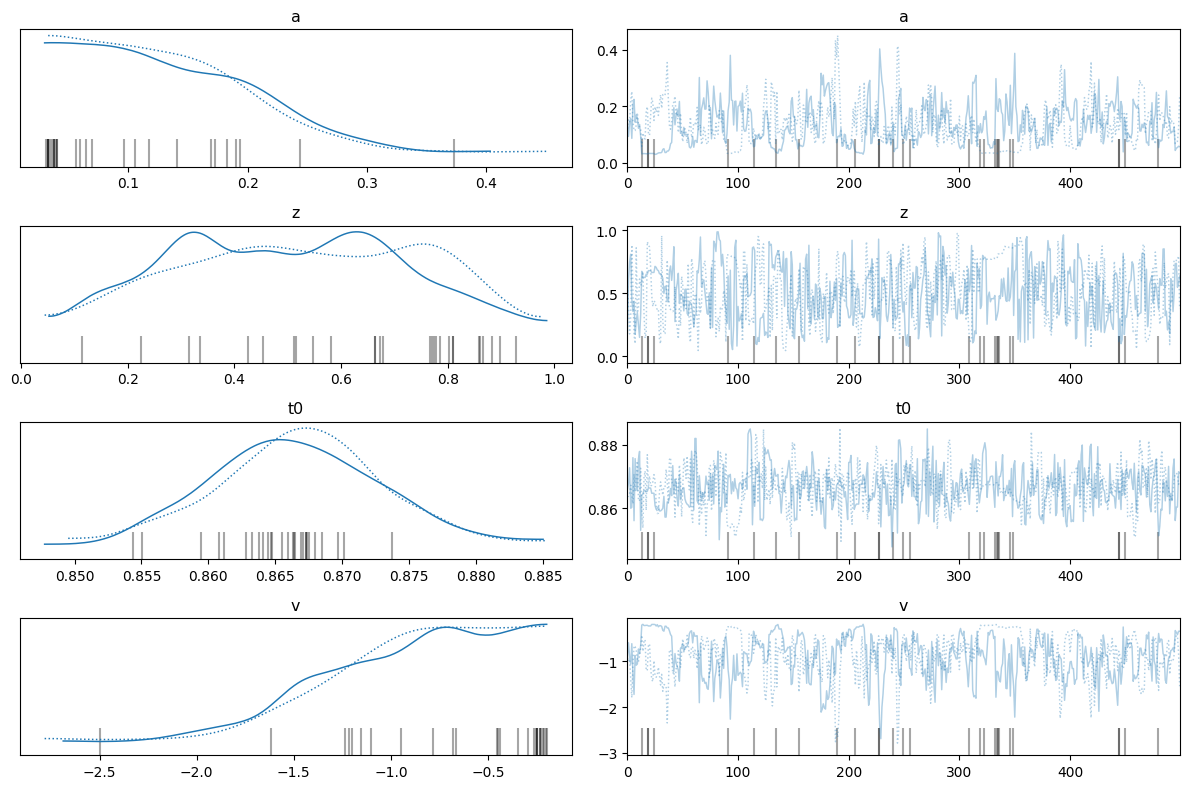

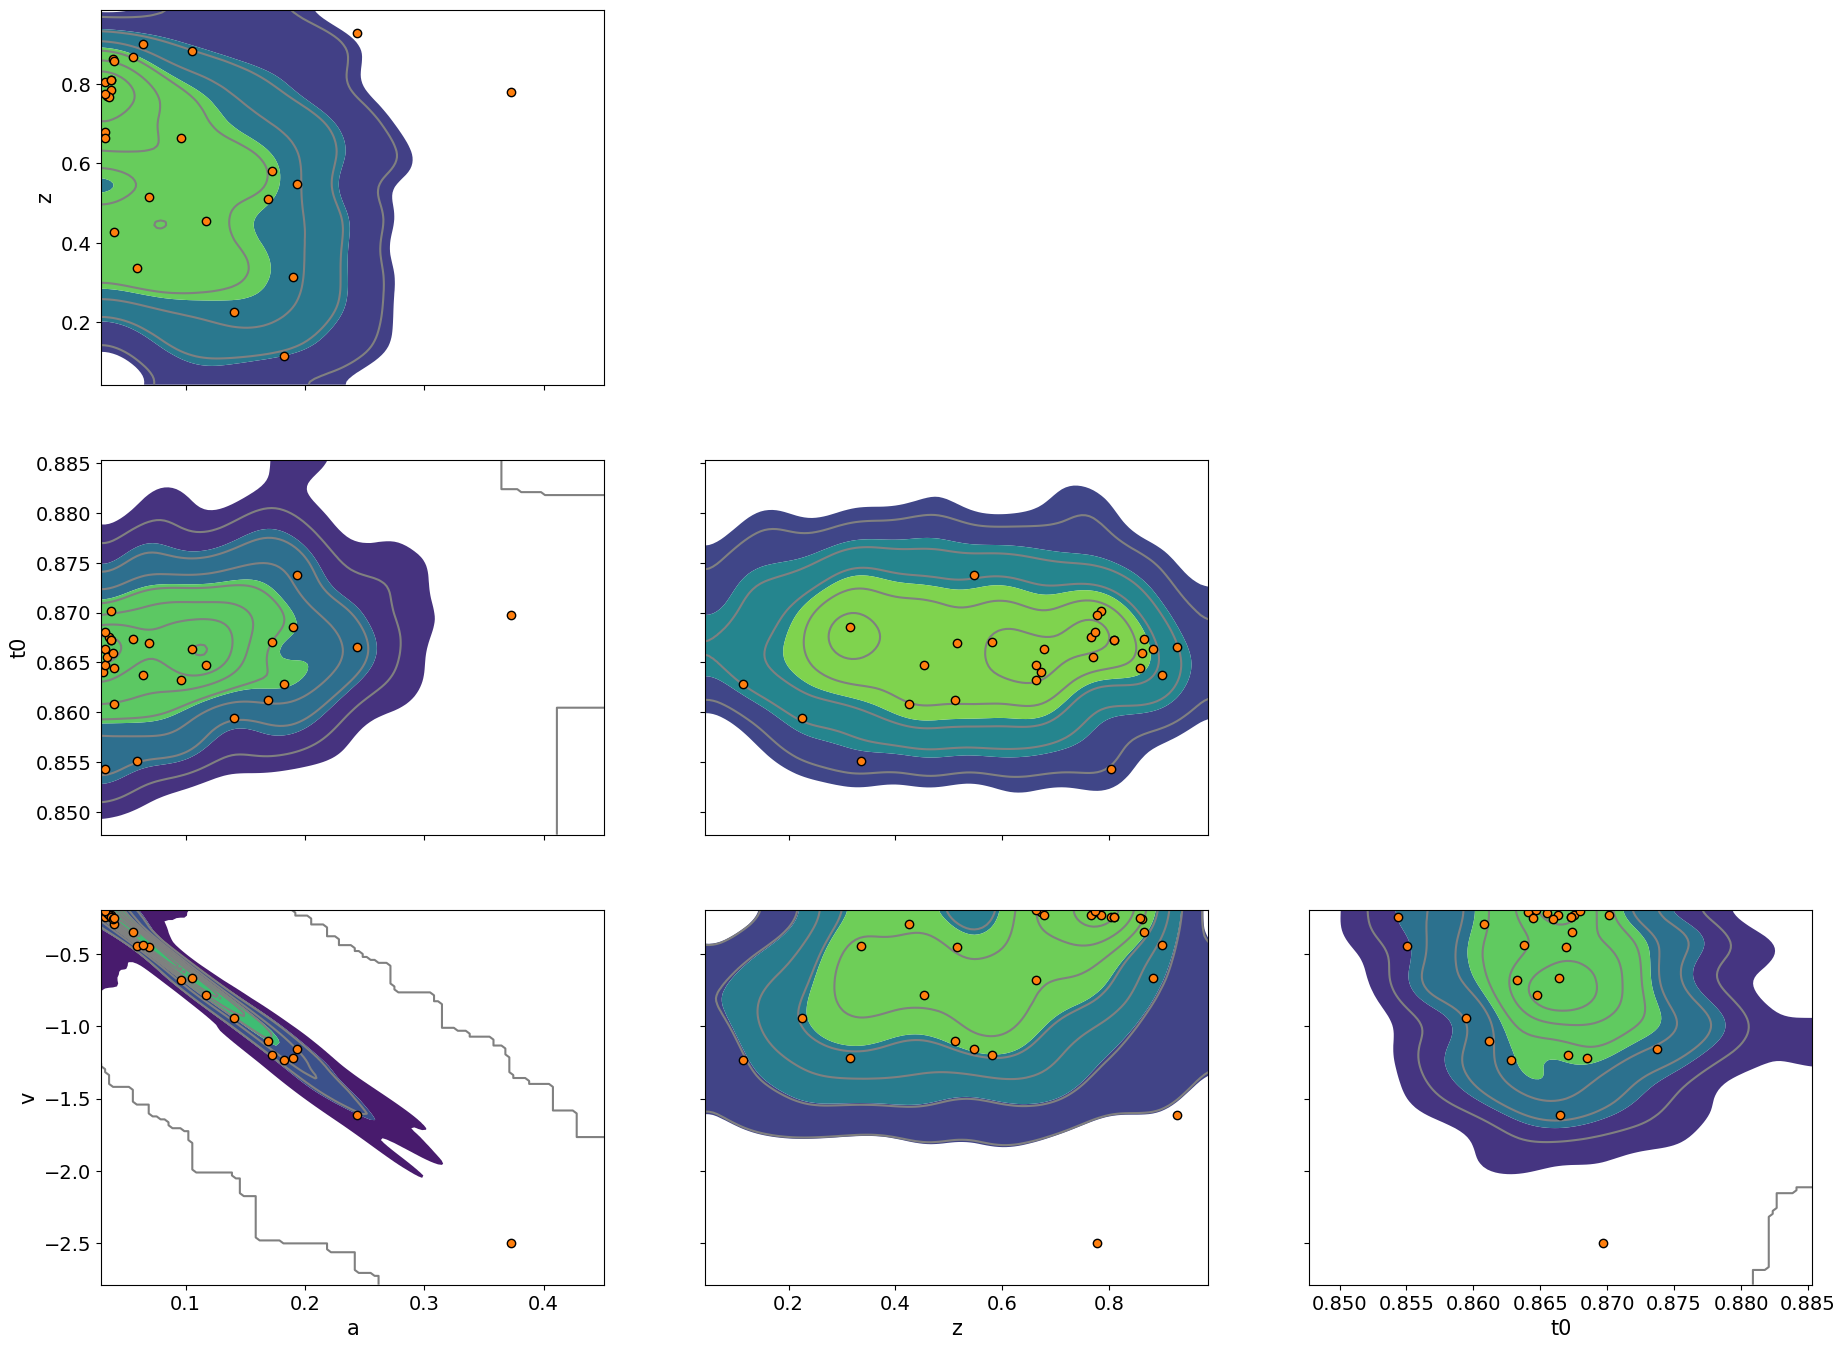

     mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
a   0.135  0.073   0.029    0.256      0.006    0.004      91.0      76.0   
z   0.513  0.227   0.107    0.883      0.015    0.012     237.0     418.0   
t0  0.867  0.006   0.854    0.878      0.000    0.000     444.0     278.0   
v  -0.880  0.467  -1.633   -0.195      0.041    0.029      87.0      68.0   

    r_hat  
a    1.02  
z    1.01  
t0   1.00  
v    1.02  


In [ ]:
import arviz as az
inf_data = az.from_cmdstanpy(fit_simple) 

az.plot_trace(inf_data, var_names=['a', 'z', 't0', 'v'])
plt.tight_layout()
plt.show()

az.plot_pair(inf_data, var_names=['a', 'z', 't0', 'v'],
             kind='kde', divergences=True)
plt.show()

summary = az.summary(inf_data, var_names=['a', 'z', 't0', 'v'])
print(summary)

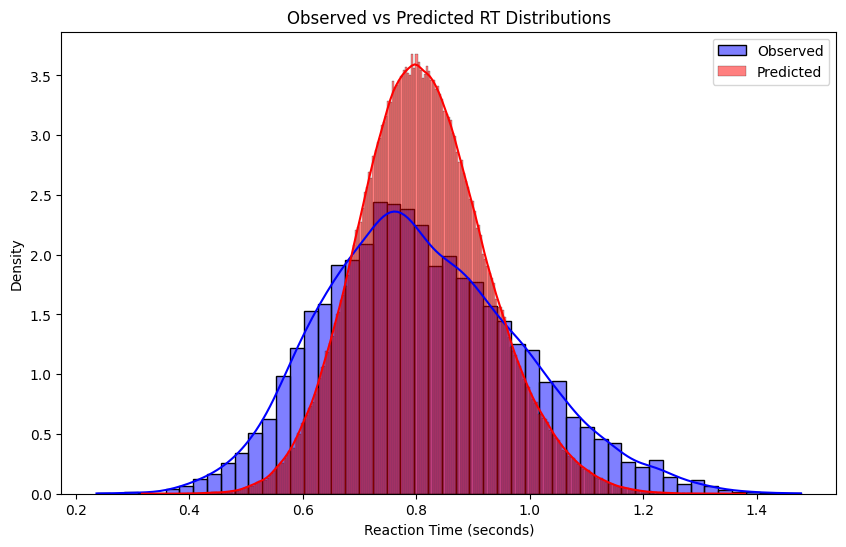

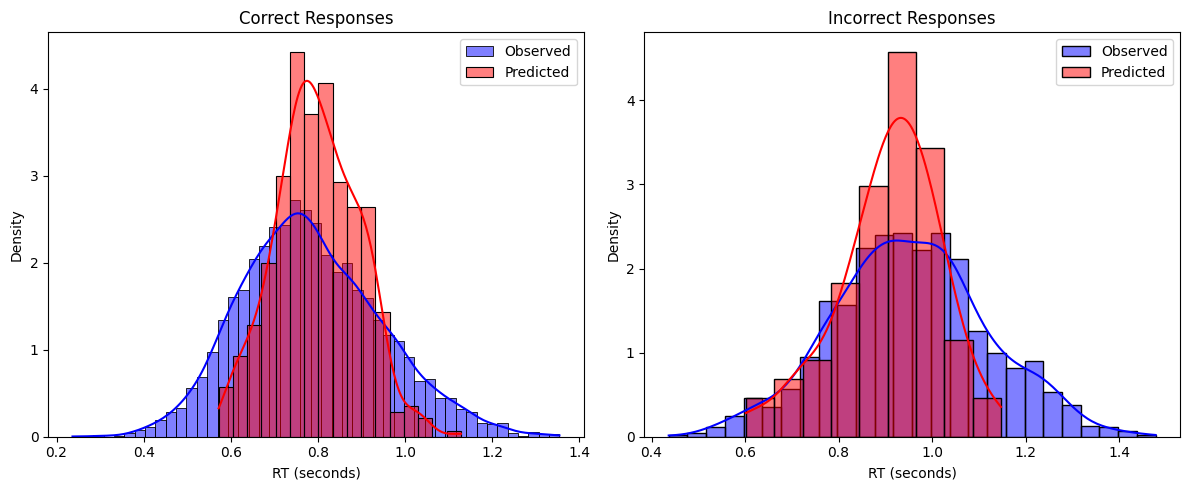

In [10]:
rt_pred = fit_simple.stan_variable('rt_pred')

plt.figure(figsize=(10, 6))
sns.histplot(sim_df['rt']/1000, kde=True, stat='density',
             label='Observed', color='blue', alpha=0.5)
sns.histplot(rt_pred.flatten(), kde=True, stat='density',
             label='Predicted', color='red', alpha=0.5)
plt.xlabel('Reaction Time (seconds)')
plt.title('Observed vs Predicted RT Distributions')
plt.legend()
plt.show()

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
obs_correct = sim_df.loc[sim_df['correct'] == 1, 'rt'] / 1000
pred_correct_idx = np.where(np.array(stan_data_simple['resp']) == 1)[0]
pred_correct = rt_pred.flatten()[pred_correct_idx]
sns.histplot(obs_correct, kde=True, stat='density',
             label='Observed', color='blue', alpha=0.5)
sns.histplot(pred_correct, kde=True, stat='density',
             label='Predicted', color='red', alpha=0.5)
plt.title('Correct Responses')
plt.xlabel('RT (seconds)')
plt.legend()

plt.subplot(1, 2, 2)
obs_incorrect = sim_df.loc[sim_df['correct'] == 0, 'rt'] / 1000
pred_incorrect_idx = np.where(np.array(stan_data_simple['resp']) == 0)[0]
pred_incorrect = rt_pred.flatten()[pred_incorrect_idx]
sns.histplot(obs_incorrect, kde=True, stat='density',
             label='Observed', color='blue', alpha=0.5)
sns.histplot(pred_incorrect, kde=True, stat='density',
             label='Predicted', color='red', alpha=0.5)
plt.title('Incorrect Responses')
plt.xlabel('RT (seconds)')
plt.legend()

plt.tight_layout()
plt.show()

In [12]:

param_means = {
    'a': fit_simple.stan_variable('a').mean(),
    'z': fit_simple.stan_variable('z').mean(),
    't0': fit_simple.stan_variable('t0').mean(),
    'v': fit_simple.stan_variable('v').mean(),
}

print("\nParameter Means:")
for param, value in param_means.items():
    print(f"{param}: {value:.4f}")

print("\nParameter Interpretations:")
print(
    f"Boundary Separation (a): {param_means['a']:.4f} - Higher values indicate more cautious decision-making")
print(
    f"Starting Point (z): {param_means['z']:.4f} - Values close to 0.5 indicate no bias")
print(
    f"Non-decision Time (t0): {param_means['t0']:.4f} seconds - Time spent on processes outside of evidence accumulation")
print(
    f"Drift Rate (v): {param_means['v']:.4f} - Higher absolute values indicate faster evidence accumulation")



Parameter Means:
a: 0.1347
z: 0.5134
t0: 0.8667
v: -0.8800

Parameter Interpretations:
Boundary Separation (a): 0.1347 - Higher values indicate more cautious decision-making
Starting Point (z): 0.5134 - Values close to 0.5 indicate no bias
Non-decision Time (t0): 0.8667 seconds - Time spent on processes outside of evidence accumulation
Drift Rate (v): -0.8800 - Higher absolute values indicate faster evidence accumulation

Note: Model comparison metrics (WAIC/LOO) require the 'log_lik' variable in the Stan model.
The simplified model doesn't include this. To enable full model comparison,
add the log_lik array to the 'generated quantities' block in your simplified Stan model.
